# Analysis of flight delays for Newark Airport

Project Brief: See project documentation for full description.

Newark airport has requested an investigation into flight departure delays.<br /> 
Flight delays are a key performance indicator of airport operations. <br /> 
The following three business questions are explored:<br /> 

- What is the impact of weather on flight departure delays
- What other reasons impact flight departure delays
- How does Newark compare to other NY airports

In [2]:
# import libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import branca

In [3]:
# read in data
ewr_flights = pd.read_csv('data/clean_data/ewr_flights.csv')

# create combined flights_all data
flight_files = ['data/clean_data/ewr_flights.csv',
                'data/clean_data/jfk_flights.csv', 
                'data/clean_data/lga_flights.csv']

flights_all = pd.concat(map(pd.read_csv, flight_files))

# Preliminary analysis

## Investigating weather data

In [4]:
# profile report for weather variables
pp.ProfileReport(ewr_flights.loc[:, ['time_hour', 'dep_delay_true', 'wind_dir',
       'wind_speed', 'wind_gust', 'visib', 'temp_max', 'temp_min',
       'temp_ave', 'temp_departure', 'ppt', 'new_snow', 'snow_depth']])

NameError: name 'pp' is not defined

### Summary of profile report on weather.
* `wind_speed` and `wind_gust` are highly positively correlated. As are all the temperature variables, `temp_max`, `temp_min`, `temp_ave`. <br />
* Precipitation (`ppt`) has a very skewed distribution and 48% of the data is zero. The two snow variables, `new_snow` and `snow_depth` have 92% zeros in their data columns. <br />
* Wind direction has a bimodal distribution. <br />

24% of the flights are delayed and 76% of the flights are not delayed.

## Investigating plane information

In [5]:
pp.ProfileReport(flights_all.loc[:,['manufacturer', 'type', 'carrier_name', 'engine', 'model']])

NameError: name 'pp' is not defined

### Summary of profile report on plane information
- The `type` variable is highly correlated with `manufacturer` and `engine`, remove this variable. <br />
- The `manufacturer` variable has high cardinality (lots of different categories). Recode this to the top 5 manufacturers, recode NaNs to unknown and set the rest to other.

# Feature engineering and data wrangling

Random forest is known to be a good model for flight delay data. I will prepare the data for this model.

## Feature engineering

The following features will be changed.

 - convert `wind_speed` into a categorical `wind_scale` using the Beaufort scale
 - drop columns with high correlation identified in pandas profiling report (`wind_gust`, `temp_max`, `temp_min`)
 - remove `type`
 - recode `manufacturer` to the top 5 manufacturers, recode NaNs to unknown and set the rest to other
 - recode `hour`, `month` and `day` as categorical variables
 - remove other columns not thought to be important for flight delay model (keep `dest_airport`): <br />
 `dest_timezone`, `dest_alt`, `dest_lon`, `dest_lat`, `dest_faa`, `ori_timezone`, `ori_lat`, `ori_lon`, <br /> `ori_airport`, `ori_faa`, `time_hour`, `minute`, `hour`, `dest`, `tailnum`, `flight`, `carrier`, `arr_delay`, <br /> 
`sched_arr_time`, `arr_time`, `dep_delay`, `sched_dep_time`, `dep_time`, `day`.

### Convert weather data types

In [6]:
# add categorical wind_scale for wind_speed
wind_labels = ['Calm', 'Light Breeze', 'Gentle Breeze', 
'Moderate Breeze', 'Fresh Breeze', 'Strong Breeze', 'Near Gale',
'Gale']

wind_bins = [0, 3, 7, 12, 18, 24, 31, 38, 46]

flights_all['wind_scale'] = pd.cut(flights_all['wind_speed'], 
bins = wind_bins, labels=wind_labels,
include_lowest = True)

In [7]:
weather_drop = ['wind_gust', 'temp_max', 'temp_min']

flights_all_trim = flights_all.drop(columns=weather_drop)

### Convert plane data types

In [8]:
flights_all_trim.drop(columns=['type', 'model'], inplace = True)

man_keep = ['Unknown', 'BOEING', 'AIRBUS', 'AIRBUS INDUSTRIE',
 'EMBRAER', 'BOMBARDIER INC', 'MCDONNELL DOUGLAS AIRCRAFT CO', 'MCDONNELL DOUGLAS']

flights_all_trim.manufacturer = np.where(flights_all_trim.manufacturer.isin(man_keep),
flights_all_trim.manufacturer, 'Other')

In [9]:
#fix manufacturer doubling for airbus and mcdonnell douglas
flights_all_trim.manufacturer = flights_all_trim.manufacturer.map({
    'AIRBUS INDUSTRIE': 'AIRBUS',
    'AIRBUS': 'AIRBUS',
    'MCDONNELL DOUGLAS': 'MCDONNELL DOUGLAS',
    'MCDONNELL DOUGLAS AIRCRAFT CO': 'MCDONNELL DOUGLAS',
    'BOEING': 'BOEING',
    'EMBRAER': 'EMBRAER', 
    'BOMBARDIER INC': 'BOMBARDIER INC',
    'Unknown': 'Unknown',
    'Other': 'Other'})

flights_all_trim.head()

,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,...,dest_faa,dest_airport,dest_lat,dest_lon,dest_alt,dest_timezone,carrier_name,manufacturer,engine,wind_scale
0,1,1,545.0,545,0.0,833.0,831,2.0,B6,527,...,MCO,Orlando International Airport,28.429399,-81.308998,96.0,America/New_York,JetBlue Airways,AIRBUS,Turbo-fan,Gentle Breeze
1,1,1,556.0,555,1.0,709.0,714,-5.0,UA,320,...,IAD,Washington Dulles International Airport,38.944500,-77.455803,312.0,America/New_York,United Air Lines Inc.,AIRBUS,Turbo-fan,Gentle Breeze
2,1,1,559.0,600,-1.0,848.0,904,-16.0,AA,1301,...,MIA,Miami International Airport,25.793200,-80.290604,8.0,America/New_York,American Airlines Inc.,Unknown,Unknown,Gentle Breeze
3,1,1,557.0,600,-3.0,853.0,903,-10.0,B6,605,...,FLL,Fort Lauderdale Hollywood International Airport,26.072599,-80.152702,9.0,America/New_York,JetBlue Airways,AIRBUS,Turbo-fan,Gentle Breeze
4,1,1,731.0,655,36.0,830.0,808,22.0,UA,2016,...,BOS,General Edward Lawrence Logan International Ai...,42.364300,-71.005203,20.0,America/New_York,United Air Lines Inc.,AIRBUS,Turbo-fan,Gentle Breeze


In [10]:
flights_all_trim.shape

(294167, 43)

### Convert timeseries data into categories

In [11]:
flights_all_trim['month_flag'] = flights_all_trim.month.astype(str)

flights_all_trim['month_flag'] = flights_all_trim['month_flag'].map({
    '1': 'Jan',
    '2': 'Feb',
    '3': 'Mar',
    '4': 'Apr',
    '5': 'May',
    '6': 'Jun', 
    '7': 'Jul',
    '8': 'Aug',
    '9': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'})

In [12]:
flights_all_trim.loc[:, 'time_hour'] = pd.to_datetime(flights_all_trim.time_hour, yearfirst=True)

flights_all_trim['weekday'] = flights_all_trim['time_hour'].dt.day_name()

flights_all_trim['hour'] = pd.Categorical(flights_all_trim['hour'], ordered = True)

In [13]:
to_drop=['dest_timezone', 'ori_alt', 'dest_lon', 'dest_lat', 'dest_faa', 
'ori_timezone', 'ori_lat', 'ori_lon', 'ori_airport', 'ori_faa', 'time_hour', 
'minute', 'dest', 'tailnum', 'flight', 'carrier', 'arr_delay', 'sched_arr_time', 
'arr_time', 'dep_delay', 'month', 'sched_dep_time','dep_time', 'day']

flights_model_data = flights_all_trim.drop(columns=to_drop)

Remove data for EWR (Newark) - save the rest of the data for future work, can run the model on the data for the other airports to see how it performs

In [14]:
# split into EWR, and the others
ewr_model_data = flights_model_data.loc[(flights_model_data['origin'] == 'EWR')].copy()

# Exploratory Data Analysis

I will start with an overview of departure delays across all airports and then move to delays at EWR, focusing on weather and other factors.

In [15]:
# set figure sizes for all plots
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

In [16]:
flights_all_trim.loc[:, 'dep_delay_count'] = flights_all_trim.groupby(['origin', 'month']).dep_delay_true.transform('sum')
flights_all_trim.loc[:, 'total_flight_count'] = flights_all_trim.groupby(['origin', 'month']).dep_delay.transform('count')
flights_all_trim.loc[:, 'percent_delay'] = (flights_all_trim.dep_delay_count / flights_all_trim.total_flight_count) * 100



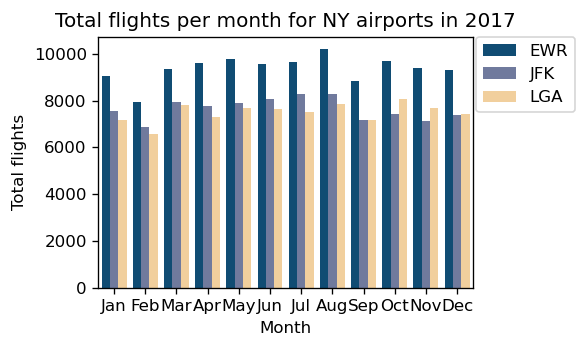

In [18]:
hue_order = ['EWR', 'JFK', 'LGA']
all_flights_pal = sns.color_palette(['#005083', '#6876a4', '#ffd28f'])

sns.barplot(
    x = 'month_flag', y = 'total_flight_count', 
    hue = 'origin', palette = all_flights_pal, 
    hue_order = hue_order, data = flights_all_trim)
plt.title("Total flights per month for NY airports in 2017")
plt.xlabel("Month")
plt.ylabel("Total flights")
plt.legend(bbox_to_anchor=(1.01, 1), loc = 2,
           borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/all_airports_total_plot.png', pad_inches=0.5);

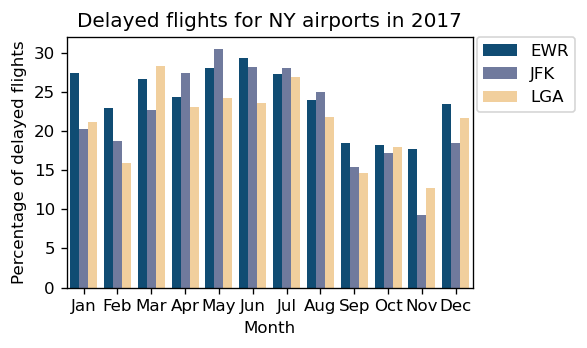

In [19]:
sns.barplot(
    x = 'month_flag', y = 'percent_delay', 
    hue = 'origin', hue_order = hue_order, 
    palette = all_flights_pal, data = flights_all_trim)
plt.title("Delayed flights for NY airports in 2017")
plt.xlabel("Month")
plt.ylabel("Percentage of delayed flights")
plt.legend(bbox_to_anchor=(1.01, 1), loc = 2,
           borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/all_airports_delays_plot.png', pad_inches=0.5);

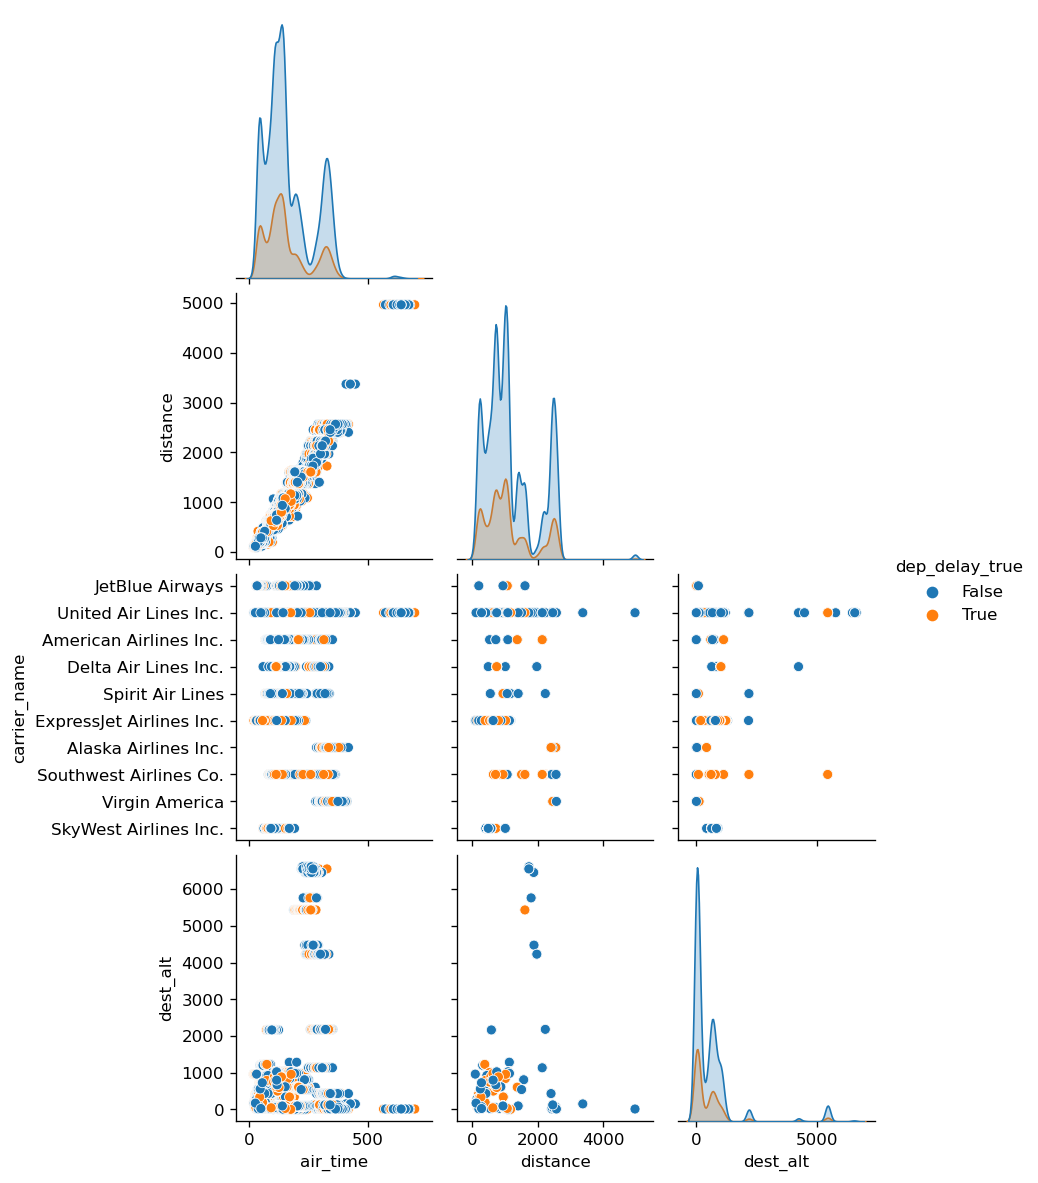

In [20]:
sns.pairplot(ewr_model_data,
x_vars=['air_time', 'distance', 'dest_alt'],
y_vars=['air_time', 'distance', 'carrier_name', 'dest_alt'],
hue = 'dep_delay_true',
corner = True);

In [21]:
ewr_all = flights_all_trim.loc[(flights_all_trim['origin'] == 'EWR')].copy().reset_index(drop = True)

In [22]:
# function to create a column with percentage of delayed flights per grouping column (col)
def percent_delay(col):
    ewr_all.loc[:, 'dep_delay_per_'+ col] = ewr_all.groupby([col]).dep_delay_true.transform('sum')
    ewr_all.loc[:, 'total_flights_per_' + col] = ewr_all.groupby([col]).dep_delay.transform('count')
    ewr_all.loc[:, 'percent_delay_per_' + col] = (ewr_all['dep_delay_per_'+ col] / ewr_all['total_flights_per_' + col]) * 100

## EDA weather and flight delays

In [23]:
# set custom graph options

line_pal = sns.color_palette(['#f9ab00', '#49006a'])

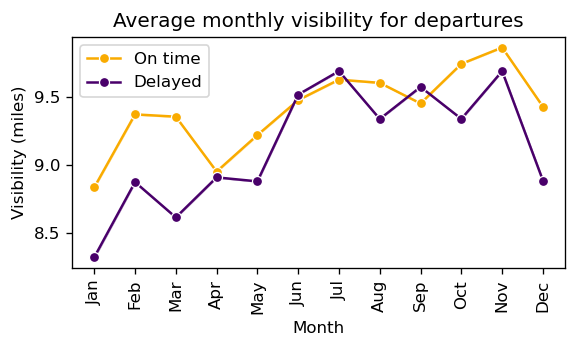

In [24]:
visib_plot = sns.lineplot(
    x = 'month_flag',
    y = 'visib',
    hue = 'dep_delay_true',
    marker = 'o',
    ci = False,
    palette = line_pal,
    data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Visibility (miles)')
plt.title('Average monthly visibility for departures')
plt.legend(title='', labels=['On time', 'Delayed'])
plt.tight_layout()
plt.savefig('figures/visib_plot.png', pad_inches=0.5);

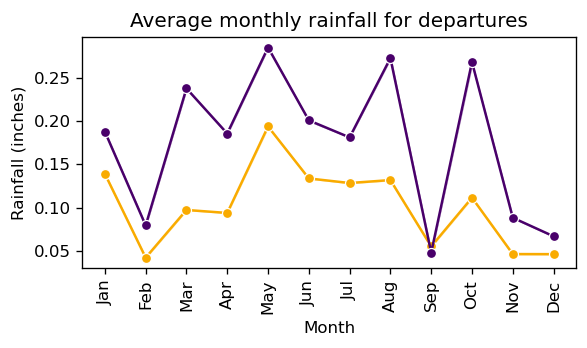

In [25]:
sns.lineplot(x = 'month_flag',
y = 'ppt',
hue = 'dep_delay_true',
marker='o',
palette = line_pal,
ci=False,
legend=False,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Rainfall (inches)')
plt.title('Average monthly rainfall for departures')
#plt.legend(title='', labels=['Not delayed', 'Delayed'])
plt.tight_layout()
plt.savefig('figures/ppt_plot.png', pad_inches=0.5);

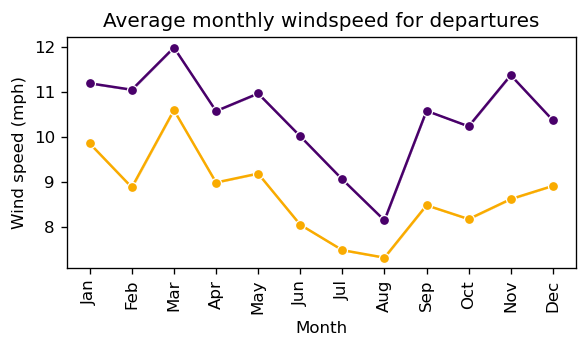

In [26]:
sns.lineplot(x = 'month_flag',
y = 'wind_speed',
hue = 'dep_delay_true',
marker='o',
palette = line_pal,
ci = False,
legend = False,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Wind speed (mph)')
plt.title('Average monthly windspeed for departures')
#plt.legend(title='', labels=['Not delayed', 'Delayed'])
plt.tight_layout()
plt.savefig('figures/windspeed_plot.png', pad_inches=0.5);


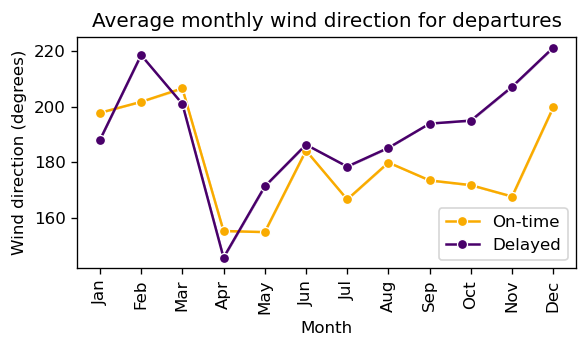

In [27]:
sns.lineplot(x = 'month_flag',
y = 'wind_dir',
hue = 'dep_delay_true',
marker='o',
palette = line_pal,
ci = False,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Wind direction (degrees)')
plt.title('Average monthly wind direction for departures')
plt.legend(title='', labels=['On-time', 'Delayed'])
plt.tight_layout()
plt.savefig('figures/wind_dir_plot.png', pad_inches=0.7);


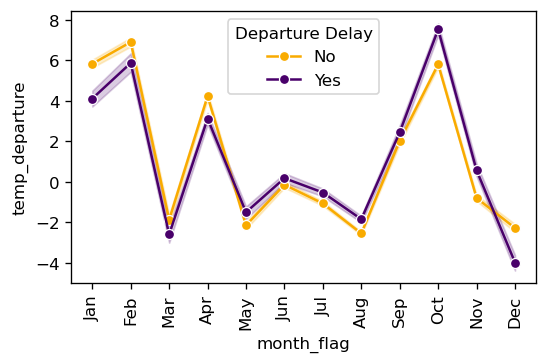

In [28]:
sns.lineplot(x = 'month_flag',
y = 'temp_departure',
hue = 'dep_delay_true',
marker='o',
palette = line_pal,
data = ewr_all)
plt.xticks(rotation=90)
plt.legend(title='Departure Delay', labels=['No', 'Yes']);

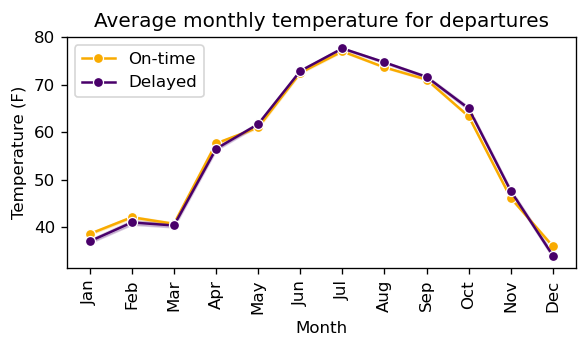

In [29]:
sns.lineplot(x = 'month_flag',
y = 'temp_ave',
marker = 'o',
hue = 'dep_delay_true',
palette = line_pal,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Temperature (F)')
plt.title('Average monthly temperature for departures')
plt.legend(title='', labels=['On-time', 'Delayed'])
plt.tight_layout()
plt.savefig('./figures/ave_temp_plot.png', pad_inches=0.7);

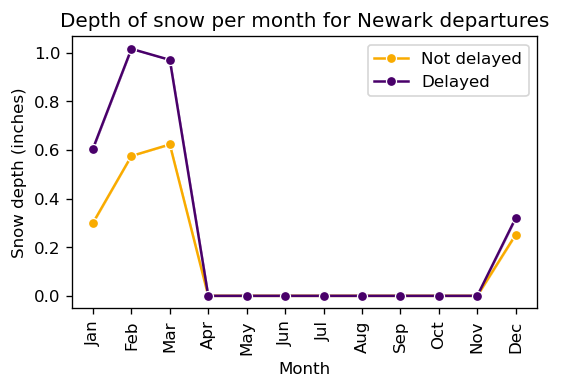

In [30]:
sns.lineplot(x = 'month_flag',
y = 'snow_depth',
marker='o',
hue = 'dep_delay_true',
palette = line_pal,
ci = False,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Snow depth (inches)')
plt.title('Depth of snow per month for Newark departures')
plt.legend(title='', labels=['Not delayed', 'Delayed']);

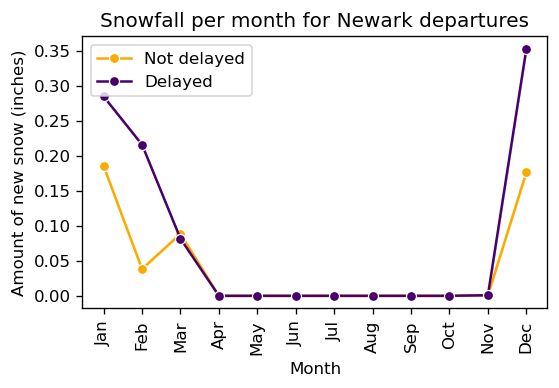

In [31]:
sns.lineplot(x = 'month_flag',
y = 'new_snow',
hue = 'dep_delay_true',
marker='o',
palette = line_pal,
ci = False,
data = ewr_all)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Amount of new snow (inches)')
plt.title('Snowfall per month for Newark departures')
plt.legend(title='', labels=['Not delayed', 'Delayed']);

### Summary

* Weather which affects departure delays year round includes `wind_speed`, `rainfall`, `wind_direction` and `visib` (visibility). 

* For the winter months, `new_snow` and `snow_depth` impact on flight delays.

For the business presentation, graphs were selected which show differences in flight delays over different months.

## EDA for other reasons for delays

### Carrier delays

In [32]:
percent_delay('carrier_name')
carrier = ewr_all.drop_duplicates(subset=['carrier_name']).reset_index(drop = True)

ordered_data = carrier.sort_values('percent_delay_per_carrier_name').carrier_name

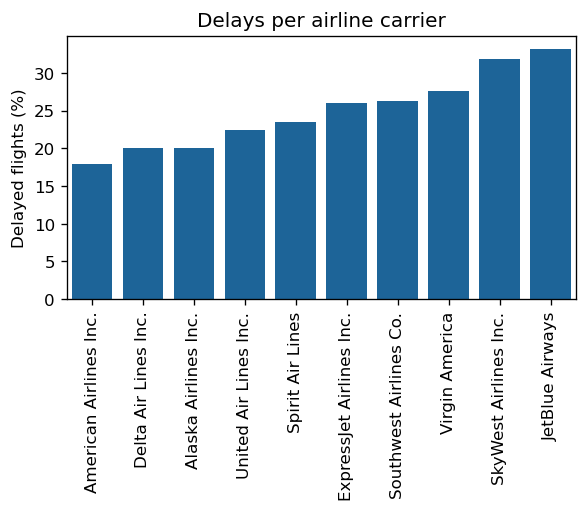

In [33]:
sns.barplot(
    x = 'carrier_name',
    y = 'percent_delay_per_carrier_name',
    color = '#0868ac',
    order = ordered_data,
    data = carrier)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Delayed flights (%)')
plt.title('Delays per airline carrier')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/carrier_delays_plot.png', dpi = 400, pad_inches=0.85, bbox_inches='tight');

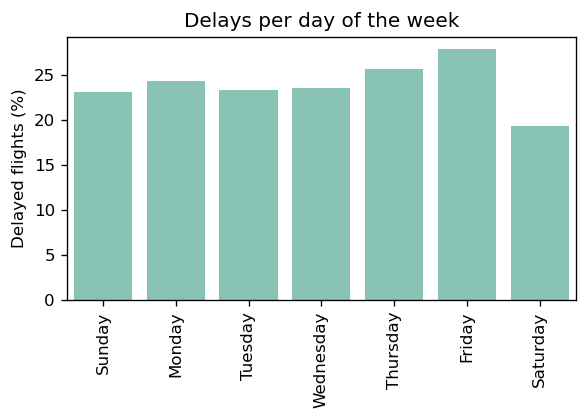

In [34]:
percent_delay('weekday')

sns.barplot(y = 'percent_delay_per_weekday',
x = 'weekday',
color = '#7fcdbb',
data = ewr_all)
plt.xticks(rotation=90)
plt.ylabel('Delayed flights (%)')
plt.xlabel('')
plt.title('Delays per day of the week')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/weekdays_plot.png', dpi = 400, pad_inches=0.85, bbox_inches='tight');

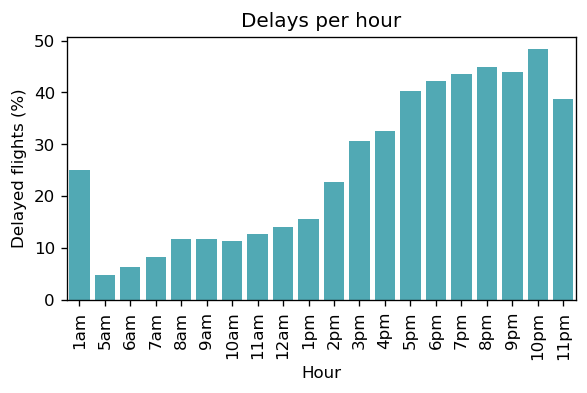

In [35]:
percent_delay('hour')

sns.barplot(
    y = 'percent_delay_per_hour',
    x = 'hour',
    color = '#41b6c4',
    data = ewr_all)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 ['1am', '5am', '6am', '7am', '8am', '9am', 
 '10am', '11am', '12am', '1pm', '2pm', '3pm', 
 '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm'],
 rotation=90)
plt.ylabel('Delayed flights (%)')
plt.xlabel('Hour')
plt.title('Delays per hour')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/hour_plot.png', dpi = 400, pad_inches=0.85, bbox_inches='tight');

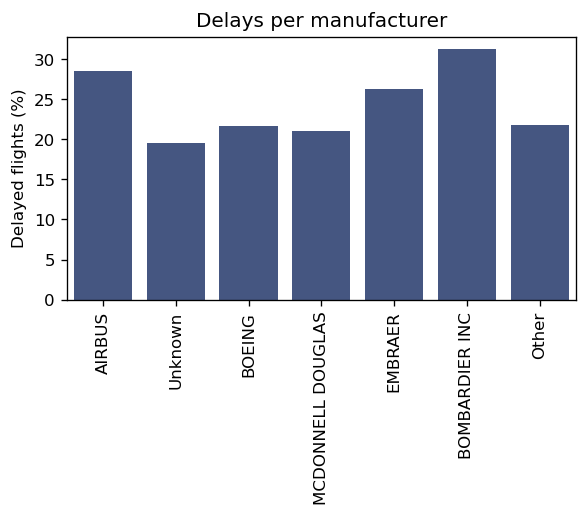

In [36]:
percent_delay('manufacturer')
#8c96c6

sns.barplot(y = 'percent_delay_per_manufacturer',
x = 'manufacturer',
color = '#3b528b',
data = ewr_all)
plt.xticks(rotation=90)
plt.ylabel('Delayed flights (%)')
plt.xlabel('')
plt.title('Delays per manufacturer')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/manufacturer_plot.png', dpi = 400, pad_inches=0.85, bbox_inches='tight');

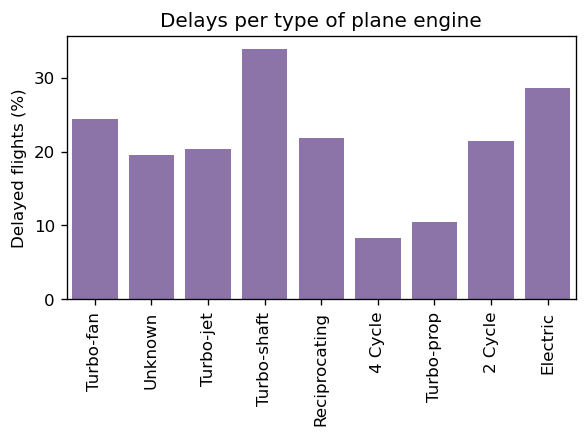

In [37]:
percent_delay('engine')

sns.barplot(y = 'percent_delay_per_engine',
x = 'engine',
color = '#8c6bb1',
data = ewr_all)
plt.xticks(rotation=90)
plt.ylabel('Delayed flights (%)')
plt.xlabel('')
plt.title('Delays per type of plane engine')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/engine_plot.png', dpi = 400, pad_inches=0.85, bbox_inches='tight');

### Summary

* Many other factors are also involved in departure delays.

* Airline carrier, time and month of departure and plane engine show the most variation in terms of total percentage flights which were delayed.

## Geospatial data exploration


The data per destination airport needs to be summarised so that it can be plotted on a map.

There are 88 different destination airports in total, all domestic (US).

Possible useful summary visuals:
- percentage delayed flights per destination airport sized by total number of flights
- percentage delayed flights per destination airport coloured/sized by delay time
- percentage delayed flights selecting top 5 delayed airlines on the route

In [38]:
# select all columns useful for geospatial analysis
ewr_geo = ewr_flights.loc[:, ['ori_airport', 'ori_lat', 'ori_lon', 
'ori_alt','dest_airport', 'dest_lat', 'dest_lon', 'carrier_name', 'dep_delay', 
'dep_delay_true', 'air_time', 'distance', 'hour', 'wind_speed', 'visib']].copy()

In [39]:
# generate percentage delay column per destination for plotting

ewr_geo.loc[:, 'dep_delay_count'] = ewr_geo.groupby(['dest_airport']).dep_delay_true.transform('sum')
ewr_geo.loc[:, 'total_flights_per_dest_airport'] = ewr_geo.groupby(['dest_airport']).dep_delay.transform('count')
ewr_geo.loc[:, 'percent_delay_per_dest_airport'] = (ewr_geo.dep_delay_count / ewr_geo.total_flights_per_dest_airport) * 100


ewr_unique_dest = ewr_geo.drop_duplicates(['dest_airport', 'percent_delay_per_dest_airport']).reset_index(drop = True)
ewr_unique_dest['percent_delay_per_dest_airport'] = ewr_unique_dest['percent_delay_per_dest_airport'].round()
ewr_unique_dest.dropna(inplace = True)

In [40]:
# remove unwanted columns
ewr_unique_dest = ewr_unique_dest.loc[:, ['ori_airport', 'ori_lat', 'ori_lon',
'dest_airport', 'dest_lat', 'dest_lon', 'total_flights_per_dest_airport', 
'percent_delay_per_dest_airport']].copy()


ewr_unique_dest = ewr_unique_dest.reset_index(drop = True)

In [42]:
# scale total flights to a value between 1 and 20 for plotting

ewr_unique_dest['scaled_flights_per_dest'] = \
    1 + (ewr_unique_dest['total_flights_per_dest_airport'] - \
         ewr_unique_dest['total_flights_per_dest_airport'].min())\
        /(ewr_unique_dest['total_flights_per_dest_airport'].max() - \
          ewr_unique_dest['total_flights_per_dest_airport'].min())\
             * 19

In [44]:
# make a color column in the dataset to iterate through in the below folium script
# bin percent delay into 9 and 5

color_hex_labels= ['#f7fcfd', '#e0ecf4', '#bfd3e6', 
                        '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d',
                        '#810f7c', '#4d004b']


ewr_unique_dest['color_hex_delay'] = pd.cut(ewr_unique_dest['percent_delay_per_dest_airport'], 
bins = 9, labels=color_hex_labels,
include_lowest = True)

In [45]:
us_map = folium.Map(location=[40.6925, -74.1687], 
zoom_start = 5,
tiles="cartodbpositron")

#iterrows returns index (stored in _) and row which we need
for _, row in ewr_unique_dest.iterrows():

    folium.CircleMarker([row['ori_lat'], row['ori_lon']],
                        radius=5,
                        fill_color='#005083', # ewr airport colour
                        stroke=False,
                        fill_opacity = 1
                       ).add_to(us_map)

    folium.CircleMarker([row['dest_lat'], row['dest_lon']],
                        radius=10,
                        fill_color=[row['color_hex_delay']], # destination colour
                        stroke=False,
                        fill_opacity = 1
                       ).add_to(us_map)

    folium.PolyLine([[row['ori_lat'], row['ori_lon']], 
                     [row['dest_lat'], row['dest_lon']]],
                     color = 'black',
                     weight= [row['scaled_flights_per_dest']], # size line on total flights
                     opacity = 0.1
                     ).add_to(us_map)

In [46]:
# create legend for map

legend = branca.colormap.StepColormap(['#f7fcfd', '#e0ecf4', '#bfd3e6', 
                        '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d',
                        '#810f7c', '#4d004b'],
                        vmin=6, vmax=54, index=[6, 11, 16, 22, 27, 32, 38, 43, 48, 54],
                        caption='Percentage of delayed flights')

legend.add_to(us_map)

In [47]:
#view map

us_map

## Summary of EDA
- Many factors involved in departure delays - weather, time of day, airline carrier, destination airport
- Uncertain of the importance of each one
- Move to a model to gain insight on factors contribution to departure delay

# Random Forest Modeling

This model was selected for the following reasons:
* several groups have used this model to successfully model flight delays [example](https://ieeexplore.ieee.org/abstract/document/9256474)
* it is relatively easy to interpret
* the relative feature importance can be used to determine features important for delays

A Random Forest Classifier was used as I classified flights as delayed (1) or not delayed (0) according to the Bureau of Transport Statistics [rules](https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays). These state that a flight is delayed if it is late by 15 minutes or more.

In [48]:
ewr_model_data.head()

,origin,air_time,distance,hour,dep_delay_true,wind_dir,wind_speed,visib,temp_ave,temp_departure,...,new_snow,snow_depth,dest_airport,dest_alt,carrier_name,manufacturer,engine,wind_scale,month_flag,weekday
0,EWR,136.0,937,5,False,220.0,11.5078,10.0,41.5,7.2,...,0.0,0.0,Orlando International Airport,96.0,JetBlue Airways,AIRBUS,Turbo-fan,Gentle Breeze,Jan,Sunday
1,EWR,45.0,212,5,False,220.0,11.5078,10.0,41.5,7.2,...,0.0,0.0,Washington Dulles International Airport,312.0,United Air Lines Inc.,AIRBUS,Turbo-fan,Gentle Breeze,Jan,Sunday
2,EWR,154.0,1085,6,False,230.0,10.9300,10.0,41.5,7.2,...,0.0,0.0,Miami International Airport,8.0,American Airlines Inc.,Unknown,Unknown,Gentle Breeze,Jan,Sunday
3,EWR,153.0,1065,6,False,230.0,10.9300,10.0,41.5,7.2,...,0.0,0.0,Fort Lauderdale Hollywood International Airport,9.0,JetBlue Airways,AIRBUS,Turbo-fan,Gentle Breeze,Jan,Sunday
4,EWR,42.0,200,6,True,230.0,10.9300,10.0,41.5,7.2,...,0.0,0.0,General Edward Lawrence Logan International Ai...,20.0,United Air Lines Inc.,AIRBUS,Turbo-fan,Gentle Breeze,Jan,Sunday


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

In [50]:
ewr_model_data.reset_index(drop=True, inplace=True)

In [51]:
ewr_model_data_trim = ewr_model_data.drop(columns=['air_time', 'wind_scale', 'origin', 'dest_alt']).copy()
ewr_model_data_trim.dropna(inplace=True)

## 1. Model test with all the data

In [52]:
# one hot encoding
ewr_model_data_trim = pd.get_dummies(ewr_model_data_trim)

# split into predictors and response
ewr_predictors = ewr_model_data_trim.drop(columns = 'dep_delay_true')
ewr_response = ewr_model_data_trim['dep_delay_true']

# list of predictor names for later labelling
ewr_X_names = list(ewr_predictors)

# convert to numpy arrays for modelling
ewr_predictors = np.nan_to_num(ewr_predictors.astype(np.float32))
ewr_response = np.array(ewr_response)

# split data into test and train
# stratify on response as it is skewed 24% to 76%
ewr_X_train, ewr_X_test, ewr_y_train, ewr_y_test = \
    train_test_split(ewr_predictors, ewr_response, test_size = 0.2, 
    random_state = 42,
    stratify = ewr_response)

### Establish a baseline model
Use a dummy classifier to test if the Random Forest model improves on the predictions.

In [53]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(random_state=42)
clf_dummy.fit(ewr_X_train, ewr_y_train)

DummyClassifier(random_state=42)

In [61]:
# model metrics for baseline model
print("Accuracy", (clf_dummy.score(ewr_X_test, ewr_y_test)) * 100)

ewr_y_pred_test = clf_dummy.predict(ewr_X_test)
ewr_y_pred_train = clf_dummy.predict(ewr_X_train)

print("MAE train", mean_absolute_error(ewr_y_train.astype('int'),
                                        ewr_y_pred_train.astype('int')))
print("MAE test", mean_absolute_error(ewr_y_test.astype('int'),
                                         ewr_y_pred_test.astype('int')))
print("AUC train", roc_auc_score(ewr_y_train, ewr_y_pred_train))
print("AUC test", roc_auc_score(ewr_y_test, ewr_y_pred_test))

Accuracy 76.02925243770315
MAE train 0.23969031442565966
MAE test 0.23970747562296857
AUC train 0.5
AUC test 0.5


In [56]:
ewr_model_all = RandomForestClassifier(
    n_estimators = 1000, #increase estimators to find a better model 
    min_samples_leaf=5, #set at 5 to remove effects of overfitting    
    random_state = 42)

ewr_model_all.fit(ewr_X_train, ewr_y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=1000, random_state=42)

In [60]:
print("Training Accuracy", (ewr_model_all.score(ewr_X_train, ewr_y_train)) * 100)
# model metrics for weather variable model
print("Test Accuracy", (ewr_model_all.score(ewr_X_test, ewr_y_test)) * 100)

ewr_y_pred_test = ewr_model_all.predict(ewr_X_test)
ewr_y_pred_train = ewr_model_all.predict(ewr_X_train)

print("MAE train", mean_absolute_error(ewr_y_train.astype('int'),
                                        ewr_y_pred_train.astype('int')))
print("MAE test", mean_absolute_error(ewr_y_test.astype('int'),
                                         ewr_y_pred_test.astype('int')))

print("AUC train", roc_auc_score(ewr_y_train, ewr_y_pred_train))
print("AUC test", roc_auc_score(ewr_y_test, ewr_y_pred_test))


Training Accuracy 83.71780692052457
Test Accuracy 79.92957746478874
MAE train 0.1628219307947543
MAE test 0.2007042253521127
AUC train 0.6811129449503028
AUC test 0.6208141872920605


This model does not improve much on the baseline model. It is also overfitting the data (shown by the higher scores for accuracy and AUC for the training dataset and the lower scares in mean absolute error (MAE)). 

Let's look at the confusion matrix

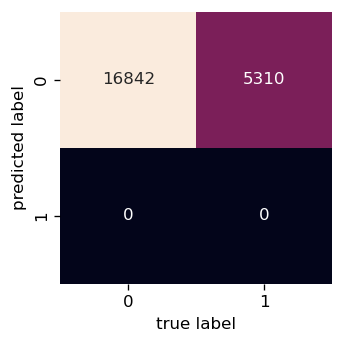

In [62]:
mat = confusion_matrix(ewr_y_test, ewr_y_pred_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
plt.xlabel('true label')
plt.ylabel('predicted label');

The model is struggling to predict true positive values (i.e. it is not predicting delayed flights well). This is most likely because the data is biased. 76% of the flights are not delayed and 24% of the flights are delayed.

In [63]:
# get numerical feature importances
importances = list(ewr_model_all.feature_importances_)

# list of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature,
                       importance in zip(ewr_X_names, importances)]

# sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: wind_speed           Importance: 0.09
Variable: temp_ave             Importance: 0.07
Variable: ppt                  Importance: 0.07
Variable: wind_dir             Importance: 0.06
Variable: temp_departure       Importance: 0.06
Variable: distance             Importance: 0.05
Variable: hour_19              Importance: 0.04
Variable: hour_20              Importance: 0.04
Variable: hour_6               Importance: 0.03
Variable: hour_17              Importance: 0.03
Variable: hour_18              Importance: 0.03
Variable: visib                Importance: 0.02
Variable: hour_7               Importance: 0.02
Variable: hour_8               Importance: 0.02
Variable: hour_21              Importance: 0.02
Variable: new_snow             Importance: 0.01
Variable: snow_depth           Importance: 0.01
Variable: hour_9               Importance: 0.01
Variable: hour_10              Importance: 0.01
Variable: hour_11              Importance: 0.01
Variable: hour_12              Importanc

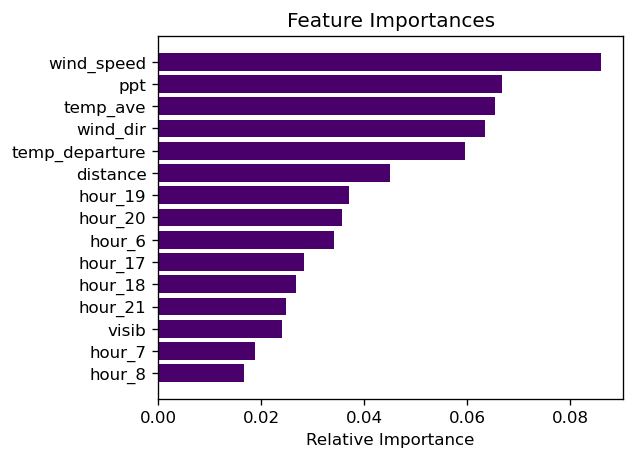

In [64]:
# make feature importance plot
features = ewr_X_names
importances = ewr_model_all.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 15 

plt.figure(figsize=(5, 4))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), 
         importances[indices[-num_features:]], color='#49006a', align='center'
        )
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

Two weather factors, `wind_speed` and precipitation (`ppt`) are important for predicting delays. As is temperature (`temp_ave` and `temp_departure`), visibility (`visib`) and wind direction (`wind_dir`). 

Hour of departure is also important. 

I will have a look at the permutation feature importance. Permutation feature importance measures how important a feature is after permuting ('shuffling' the data). If permutation of the feature causes an increase in model error then this feature is important. On the other hand if permutation does not affect model error then this feature is not important for the model.

In [ ]:
# permutation importance
result = permutation_importance(ewr_model_all, ewr_X_test, ewr_y_test, n_repeats=10,
random_state=42, n_jobs=2)

for i in result.importances_mean.argsort()[::-1]: 
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{ewr_X_names[i]:<8}"
        f"{result.importances_mean[i]:.3f}"
        f" +/- {result.importances_std[i]:.3f}")

From the results of the permutation importance, I can remove `air_time`, `wind_scale`, `dest_airport`, `dest_alt`, `distance`, `engine`, `manufacturer`, `snow_depth`, `new_snow`.

## 2. Model with unimportant features removed

In [ ]:
ewr_model_data.shape

In [ ]:
ewr_model_trim = ewr_model_data.drop(
    columns=['air_time', 'wind_scale', 'dest_airport', 'dest_alt', 
    'distance', 'engine', 'manufacturer', 'snow_depth', 'new_snow']).copy()

ewr_model_trim.dropna(inplace=True)

ewr_model_trim.shape

In [ ]:
# one hot encoding
ewr_model_trim = pd.get_dummies(ewr_model_trim)

# split into predictors and response
ewr_predictors = ewr_model_trim.drop(columns = 'dep_delay_true')
ewr_response = ewr_model_trim['dep_delay_true']

# list of predictor names for later labelling
ewr_X_names = list(ewr_predictors)

# convert to numpy arrays for modelling
ewr_predictors = np.nan_to_num(ewr_predictors.astype(np.float32))
ewr_response = np.array(ewr_response)

# split data into test and train
# stratify on response as it is skewed 24% to 76%
ewr_X_train, ewr_X_test, ewr_y_train, ewr_y_test = \
    train_test_split(ewr_predictors, ewr_response, test_size = 0.2, 
    random_state = 42,
    stratify = ewr_response)

Again, establish a baseline for the model using a dummy classifier.

In [ ]:
clf_dummy = DummyClassifier(random_state=42)
clf_dummy.fit(ewr_X_train, ewr_y_train)

# model metrics for baseline model
print("Accuracy", (clf_dummy.score(ewr_X_test, ewr_y_test)) * 100)

ewr_y_pred_test = clf_dummy.predict(ewr_X_test)
ewr_y_pred_train = clf_dummy.predict(ewr_X_train)

print("MAE train", mean_absolute_error(ewr_y_train.astype('int'),
                                        ewr_y_pred_train.astype('int')))
print("MAE test", mean_absolute_error(ewr_y_test.astype('int'),
                                         ewr_y_pred_test.astype('int')))
print("AUC train", roc_auc_score(ewr_y_train, ewr_y_pred_train))
print("AUC test", roc_auc_score(ewr_y_test, ewr_y_pred_test))

In [ ]:
ewr_model_final = RandomForestClassifier(n_estimators = 1000,
                                    min_samples_leaf=3,
                                    random_state = 42)

ewr_model_final.fit(ewr_X_train, ewr_y_train)

In [ ]:
# model metrics for final model
print("Training Accuracy", (ewr_model_final.score(ewr_X_train, ewr_y_train)) * 100)
print("Test Accuracy", (ewr_model_final.score(ewr_X_test, ewr_y_test)) * 100)

ewr_y_pred_test = ewr_model_final.predict(ewr_X_test)
ewr_y_pred_train = ewr_model_final.predict(ewr_X_train)

print("MAE train", mean_absolute_error(ewr_y_train.astype('int'),
                                        ewr_y_pred_train.astype('int')))
print("MAE test", mean_absolute_error(ewr_y_test.astype('int'),
                                         ewr_y_pred_test.astype('int')))
print("AUC train", roc_auc_score(ewr_y_train, ewr_y_pred_train))
print("AUC test", roc_auc_score(ewr_y_test, ewr_y_pred_test))

In [ ]:
# generate confusion matrix
mat = confusion_matrix(ewr_y_test, ewr_y_pred_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# get numerical feature importances
importances = list(ewr_model_final.feature_importances_)

# list of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, 
                       importance in zip(ewr_X_names, importances)]

# sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# make feature importance plot
features = ewr_X_names
importances = ewr_model_final.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 15 

plt.figure(figsize=(5, 4))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='#49006a', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
result = permutation_importance(ewr_model_final, ewr_X_test, ewr_y_test, n_repeats=10,
random_state=42, n_jobs=2)

for i in result.importances_mean.argsort()[::-1]: 
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{ewr_X_names[i]:<8}"
        f"{result.importances_mean[i]:.3f}"
        f" +/- {result.importances_std[i]:.3f}")

In [ ]:
# make permutation importance plot
features = ewr_X_names
importances = result.importances_mean
indices = np.argsort(importances)

# customized number 
num_features = 15 

plt.figure(figsize=(5, 4))
plt.title('Permutation Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='#49006a', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

#### Format permutation feature importance plot for presentation

As this permutation feature importance plot was from the final model, format the plot so it is presentation worthy. This plot will be presented back to the client to inform on features contributing to flight departure delays.

Note - this is not a DRY (don't repeat yourself) way of changing the names in this list, but it was the fastest way I could think of at the time.

In [ ]:
# change axis labels

df = pd.DataFrame(ewr_X_names)
df.replace('wind_speed', 'Wind Speed', inplace=True)
df.replace('ppt', 'Precip', inplace=True)
df.replace('hour_19', '7pm', inplace=True)
df.replace('hour_20', '8pm', inplace=True)
df.replace('hour_17', '5pm', inplace=True)
df.replace('hour_17', '5pm', inplace=True)
df.replace('hour_21', '9pm', inplace=True)
df.replace('hour_18', '6pm', inplace=True)
df.replace('hour_6', '6am', inplace=True)
df.replace('carrier_name_United Air Lines Inc.', 'United Air Lines Inc.', inplace=True)
df.replace('carrier_name_JetBlue Airways', 'JetBlue Airways', inplace=True)

ewr_X_names = list(df[0])

In [ ]:
# make permutation importance plot
features = ewr_X_names
importances = result.importances_mean
indices = np.argsort(importances)

# customized number 
num_features = 10

plt.figure(figsize=(8, 5))
plt.title('Top 10 Features')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='#49006a', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('./figures/model_importance_plot.png', dpi = 250, pad_inches=0.85);

 - bias in the response variable of departure delays (76% to 24% delayed) is proving difficult to model
 - if want to improve the model can try synthetically inflating the delayed numbers to get the ratio closer to 50%
 - consider this if run this model again

 Also - plot ROC for different models on the same axis to allow visual comparison to be made.

# Summary and conclusions
- High precipitation and wind speed cause delays
- Flights departing after 5pm have larger delays
- Don't fly United Air Lines Inc. or Jet Blue Airways
